In [193]:
# Pytorch and tools
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from RunningEnv import EnvWrapper
from Experiments import ActorCriticExperiment
from Experiments import BatchActorCriticExperiment
from Learners import ReinforceLearner
from Learners import BatchReinforceLearner
from Learners import ActorCriticLearner
from Learners import OffpolicyActorCriticLearner
from Learners import PPOLearner
from Learners import BatchOffpolicyActorCriticLearner, BatchPPOLearner, OPPOSDLearner
import pickle

In [194]:
pref_pace = 181
target_pace = pref_pace * 1.1

In [195]:
def default_params():
    """ These are the default parameters used int eh framework. """
    return {  # Debugging outputs and plotting during training
        'plot_frequency': 10,  # plots a debug message avery n steps
        'plot_train_samples': True,  # whether the x-axis is env.steps (True) or episodes (False)
        'print_when_plot': True,  # prints debug message if True
        'print_dots': False,  # prints dots for every gradient update
        # Environment parameters
        'env': 'CartPole-v0',  # the environment the agent is learning in
        'run_steps': 0,  # samples whole episodes if run_steps <= 0
        'max_episode_length': 500,  # maximum number of steps per episode
        # Runner parameters
        'max_episodes': int(1E6),  # experiment stops after this many episodes
        'max_batch_episodes': int(1E6),  # experiment stops after this many batch
        'max_steps': int(1E9),  # experiment stops after this many steps
        'multi_runner': False,  # uses multiple runners if True
        'parallel_environments': 4,  # number of parallel runners  (only if multi_runner==True)
        # Exploration parameters
        'epsilon_anneal_time': int(5E3),  # exploration anneals epsilon over these many steps
        'epsilon_finish': 0.1,  # annealing stops at (and keeps) this epsilon
        'epsilon_start': 1,  # annealing starts at this epsilon
        # Optimization parameters
        'lr': 1E-4,  # 5E-4,                       # learning rate of optimizer
        'gamma': 0.99,  # discount factor gamma
        'batch_size': 2048,  # number of transitions in a mini-batch
        'grad_norm_clip': 1,  # gradent clipping if grad norm is larger than this
        # DQN parameters
        'replay_buffer_size': int(1E5),  # the number of transitions in the replay buffer
        'use_last_episode': True,  # whether the last episode is always sampled from the buffer
        'target_model': True,  # whether a target model is used in DQN
        'target_update': 'soft',  # 'soft' target update or hard update by regular 'copy'
        'target_update_interval': 10,  # interval for the 'copy' target update
        'soft_target_update_param': 0.01,  # update parameter for the 'soft' target update
        'double_q': True,  # whether DQN uses double Q-learning
        'grad_repeats': 1,  # how many gradient updates / runner call
        # Image input parameters
        'pixel_observations': False,  # use pixel observations (we will not use this feature here)
        'pixel_resolution': (78, 78),  # scale image to this resoluton
        'pixel_grayscale': True,  # convert image into grayscale
        'pixel_add_last_obs': True,  # stacks 2 observations
        'pixel_last_obs_delay': 3,  # delay between the two stacked observations

        # Runners env
        'pref_pace': 181,  # Athlete's preferred pace
        'target_pace': pref_pace * 1.1,  # Athlete's target pace
        'states_shape': (1,),  # Amount of states
        'num_actions': 5,  # Possible actions
    }

In [196]:
def test_in_environment(experiment, env):
    done = False
    env.reset()
    state = env.step(0)[0]
    try_scores = []

    for _ in range(50):
        env.reset()
        state = env.step(0)[0]
        done = False
        score = 0
        time_step = 0
        while env.steps < 500:
            pred = th.nn.functional.softmax(model_actor(th.tensor(state, dtype=th.float32).unsqueeze(dim=-1))[:, :n_actions], dim=-1)
            action = th.distributions.Categorical(probs=pred).sample()
            new_state, reward, done = env.step(action)
            score += reward
            state = new_state
            if action > 0:
                time_step = time_step + env.times[action % 5]
            else:
                time_step = time_step + 1
        try_scores.append(score)
    print(np.array(try_scores).mean())

    # Print one episode

    env.reset()
    state = env.step(0)[0]
    rewards = 0

    while env.steps < 500:
        pred = th.nn.functional.softmax(model_actor(th.tensor(state, dtype=th.float32).unsqueeze(dim=-1))[:, :n_actions], dim=-1)
        action = th.distributions.Categorical(probs=pred).sample()
        new_state, reward, done = env.step(action)
        # if reward < 0:
        #     print(action, state, new_state, reward)
        # if (action != 5):
        # #     # print(action, (state+1)*pref_pace, (new_state+1)*pref_pace, reward)
        # print(action, state, new_state, reward)
        rewards += reward
        state = new_state

    x = np.linspace(0, len(env.env_pacing), len(env.env_pacing))
    plt.figure()
    plt.scatter(x[np.array(env.env_pacing) == 1], np.array(env.pace)[np.array(env.env_pacing) == 1], marker="x",
                label='Paced steps')
    plt.scatter(x[np.array(env.env_pacing) == 0], np.array(env.pace)[np.array(env.env_pacing) == 0], marker="x",
                label='Not-paced steps')

    # plt.scatter(x[np.array(env_pacing)==1], np.array(pace)[np.array(env_pacing)==1], marker="x", label='Paced steps')
    # plt.scatter(x[np.array(env_pacing)==0], np.array(pace)[np.array(env_pacing)==0], marker="x", label='Not-paced steps')

    # plt.scatter(x[np.array(pacing)==1], np.array(pacing)[np.array(pacing)==1]*181, color='r', marker="x")
    plt.axhline(y=target_pace, color='k', linestyle='--', label='Target Pace')

    plt.plot(x, env.state_traj, 'r-', linewidth=2)
    plt.legend()
    plt.show()

    print(rewards)

In [197]:
def plot_experiments(experiments, names):
    # sns.set()
    colors = ['b', 'g', 'r']
    plt.figure(figsize=(8, 6), dpi=80)
    i = 0
    for exp in experiments:
        # Smooth curves
        window = max(int(len(exp.episode_returns) / 50), 10)
        print(window)
        # if len(exp.episode_losses) < window + 2: return
        returns = np.convolve(exp.episode_returns, np.ones(window) / window, 'valid')
        # Determine x-axis based on samples or episodes
        x_returns = [i + window for i in range(len(returns))]
        plt.plot(x_returns, returns, colors[i], label=names[i])
        plt.xlabel('environment steps' if exp.plot_train_samples else 'batch trainings')
        plt.ylabel('episode return')
        i+=1
    plt.legend()

In [205]:
online_experiments = []
batch_size = 1000
max_batch_episodes = 200

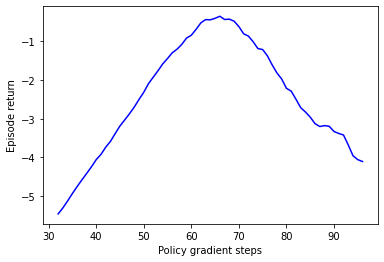

In [206]:
params = default_params()
params['plot_train_samples'] = False
params['plot_frequency'] = 4
params['batch_size'] = int(batch_size)
params['offpolicy_iterations'] = 64
params['max_batch_episodes'] = int(max_batch_episodes)
params['epsilon_anneal_time'] = 70000
params['epsilon_finish'] = 0.05
env = EnvWrapper(params.get('pref_pace'), params.get('target_pace'))
n_actions, state_dim = params.get('num_actions'), params.get('states_shape')[0]
# The model has n_action policy heads and one value head
model_actor = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 512), th.nn.ReLU(),
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions + 1))
model_critic = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 1))
model_w = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 1), th.nn.Softplus())
model = [model_actor, model_critic, model_w]
experiment = ActorCriticExperiment(params, model, learner=ActorCriticLearner(model, params=params))

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()
return_dict = {}
return_dict.update({'model' : 'AC',
                            'experiment': experiment})
online_experiments = np.append(online_experiments, return_dict)

In [211]:
experiment.controller.epsilon()

0

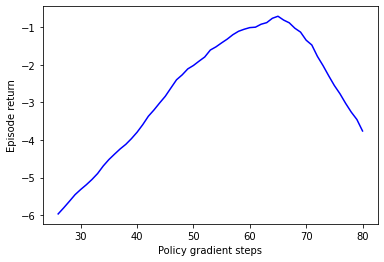

In [212]:
params = default_params()
params['plot_train_samples'] = False
params['plot_frequency'] = 4
params['batch_size'] = int(batch_size)
params['offpolicy_iterations'] = 64
params['max_batch_episodes'] = int(max_batch_episodes)
params['epsilon_anneal_time'] = 70000
params['epsilon_finish'] = 0.05
env = EnvWrapper(params.get('pref_pace'), params.get('target_pace'))
n_actions, state_dim = params.get('num_actions'), params.get('states_shape')[0]
# The model has n_action policy heads and one value head
model_actor = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 512), th.nn.ReLU(),
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions + 1))
model_critic = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 1))
model_w = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 1), th.nn.Softplus())
model = [model_actor, model_critic, model_w]
experiment = ActorCriticExperiment(params, model, learner=OffpolicyActorCriticLearner(model, params=params))

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()
return_dict = {}
return_dict.update({'model' : 'OFFPAC',
                            'experiment': experiment})
online_experiments = np.append(online_experiments, return_dict)

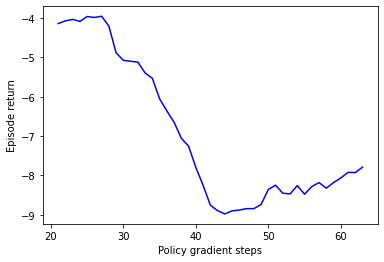

In [201]:
params = default_params()
params['plot_train_samples'] = False
params['plot_frequency'] = 4
params['batch_size'] = int(batch_size)
params['offpolicy_iterations'] = 64
params['max_batch_episodes'] = int(max_batch_episodes)
params['epsilon_anneal_time'] = 70000
params['epsilon_finish'] = 0
env = EnvWrapper(params.get('pref_pace'), params.get('target_pace'))
n_actions, state_dim = params.get('num_actions'), params.get('states_shape')[0]
# The model has n_action policy heads and one value head
model_actor = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 512), th.nn.ReLU(),
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions + 1))
model_critic = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 1))
model_w = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 1), th.nn.Softplus())
model = [model_actor, model_critic, model_w]
experiment = ActorCriticExperiment(params, model, learner=PPOLearner(model, params=params))

# Re-executing this code-block picks up the experiment where you left off
try:
    experiment.run()
except KeyboardInterrupt:
    experiment.close()
experiment.plot_training()
return_dict = {}
return_dict.update({'model' : 'PPO',
                            'experiment': experiment})
online_experiments = np.append(online_experiments, return_dict)

In [ ]:
model_actor = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 512), th.nn.ReLU(),
                         th.nn.Linear(512, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions + 1))

In [ ]:
number = 3000
# state 0
states = np.random.randint(-6, high=28, size=(number,))
# state 1
states = np.append(states, np.random.randint(29, high=47, size=int(number/2,)))
states = np.append(states, np.random.randint(-27, high=-7, size=int(number/2,)))
# state 2
states = np.append(states, np.random.randint(48, high=60, size=int(number/2,)))
states = np.append(states, np.random.randint(-40, high=-28, size=int(number/2,)))
# state 3
states = np.append(states, np.random.randint(61, high=70, size=int(number/2,)))
states = np.append(states, np.random.randint(-50, high=-41, size=int(number/2,)))
# state 4
states = np.append(states, np.random.randint(71, high=110, size=int(number/2,)))
states = np.append(states, np.random.randint(-110, high=-51, size=int(number/2,)))

states = states / 100
states = th.tensor(states, dtype=th.float32).unsqueeze(dim=-1)

# nomalized_data = (states - th.mean(states)) / th.sqrt(th.var(states))

y = get_probabilities(states)

data = np.append(states, y, axis=-1)

trainloader = th.utils.data.DataLoader(data, batch_size=50,
                                          shuffle=True)

In [202]:
losses = []
init_optimizer = th.optim.SGD(model_actor.parameters(), lr=0.02, momentum=0.9)
init_loss_func = th.nn.CrossEntropyLoss()
for epoch in range (20):
    loss_ep = []
    for x in trainloader:
        init_optimizer.zero_grad()
        y = x[:,-5:]
        mx = model_actor(x[:, 0].unsqueeze(dim=-1))[:, :n_actions]
        pred = th.nn.functional.softmax(mx, dim=-1)
        loss = init_loss_func(pred, y)
        loss_ep = np.append(loss_ep, loss.detach())
        loss.backward()
        init_optimizer.step()

    losses = np.append(losses, np.mean(loss_ep))
    if (epoch + 1)% 5 == 0:
        print('Epoch: %s, Loss: %f'% (epoch, losses[-1:]))

Epoch: 4, Loss: 1.699829
Epoch: 9, Loss: 1.699829
Epoch: 14, Loss: 1.699829
Epoch: 19, Loss: 1.699829


In [203]:
heuristic_score = []
for _ in range(500):
    env.reset()
    state = env.step(0)[0]
    done = False
    score = 0
    time_step = 0
    while not done:
        pred = th.nn.functional.softmax(model_actor(th.tensor(state, dtype=th.float32).unsqueeze(dim=-1))[:, :n_actions], dim=-1)
        action = th.distributions.Categorical(probs=pred).sample()
        new_state, reward, done = env.step(action)
        score += reward
        state = new_state
    heuristic_score.append(score[0])

Text(0.5, 1.0, 'Running environment')

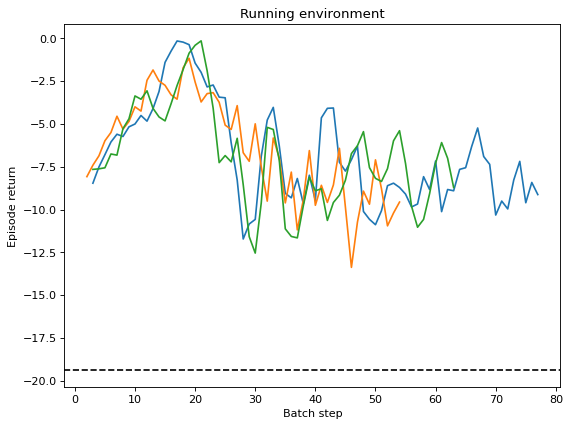

In [204]:
plt.figure(figsize=(8, 6), dpi=80)
i = 0

for exp in online_experiments:
    window = max(int(len(exp['experiment'].episode_returns) / 20), 1)
    # if len(exp.episode_losses) < window + 2: return
    returns = np.convolve(exp['experiment'].episode_returns, np.ones(window) / window, 'valid')
    # Determine x-axis based on samples or episodes
    x_returns = [i + window for i in range(len(returns))]
    plt.plot(x_returns, returns, label=exp['model'])
plt.axhline(y=np.mean(heuristic_score), color='k', linestyle='--', label='Heuristic algorithm average score')
plt.xlabel('Batch step')
plt.ylabel('Episode return')
# plt.legend(['OFFPAC', 'PPO Learner', 'Heuristic agent average score'])
plt.title('Running environment')

In [7]:
# try:
#     experiment.run()
# except KeyboardInterrupt:
#     experiment.close()
# experiment.plot_training()

In [7]:
batch_experiments = []

In [91]:

params = default_params()
params['plot_train_samples'] = False
params['plot_frequency'] = 4
params['batch_size'] = int(3200)
params['offpolicy_iterations'] = 10
params['opposd'] = True
# params['epsilon_start'] = 0.5
# params['epsilon_finish'] = 0
params['max_batch_episodes'] = int(300)
params['mini_batch_size'] = int(1000)

# params['experiments_batch'] = True
# params['max_episode_length'] = int(3)
# params['epsilon_finish'] = 0.05
# params['epsilon_anneal_time'] = 70000
env = EnvWrapper(params.get('pref_pace'), params.get('target_pace'))
n_actions, state_dim = params.get('num_actions'), params.get('states_shape')[0]
# The model has n_action policy heads and one value head
model_actor = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions))
model_critic = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 1))
model_w = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 1), th.nn.Softplus())
model = [model_actor, model_critic, model_w]
experiment = BatchActorCriticExperiment(params, model, learner=OPPOSDLearner(model, params=params))

# batch = experiment.get_transition_batch()
# dbfile = open('random_simulator_batch_steps_pickle_2e3', 'ab')
# pickle.dump(batch, dbfile)
# dbfile.close()


In [59]:
dbfile = open('random_simulator_batch_steps_pickle_3e3', 'ab')
pickle.dump(batch, dbfile)
dbfile.close()

In [92]:
# dbfile = open('random_simulator_batch_pickle', 'rb')
dbfile = open('random_simulator_batch_steps_pickle_1e4', 'rb')
# dbfile = open('random_simulator_batch_steps_pickle_5e3', 'rb')
# dbfile = open('random_simulator_batch_steps_pickle_2e3', 'rb')
# dbfile = open('experiments_simulator_batch_steps_pickle_3e3', 'rb')
# dbfile = open('random_simulator_batch_steps_pickle_3e3', 'rb')
# dbfile = open('random_simulator_batch_steps_pickle_5e2', 'rb') # Do not work
batch = pickle.load(dbfile)
dbfile.close()

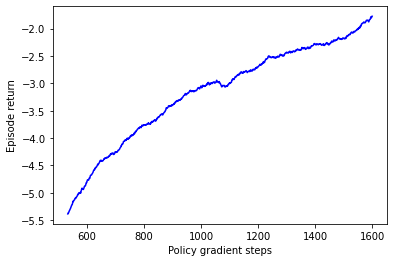

Batch 1600, epi-return -1.9 +- 3.53


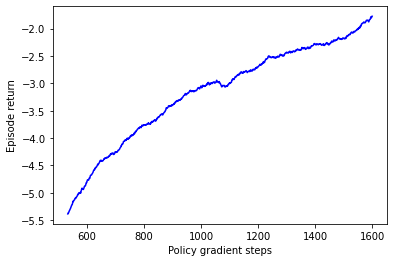

In [93]:

try:
    experiment.run(batch['buffer'])
except KeyboardInterrupt:
    experiment.close()
return_dict = {}
return_dict.update({'model' : 'Batch OPPOSD',
                            'experiment': experiment})
batch_experiments = np.append(batch_experiments, return_dict)

In [20]:
(batch['buffer']['actions'][batch['buffer']['rewards']>0]==0).sum()

tensor(133)

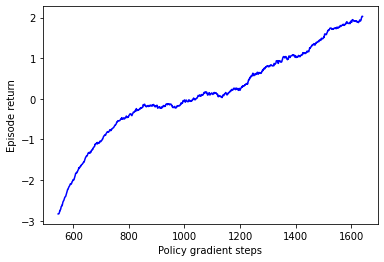

Batch 1640, epi-return 3.7 +- 5.06


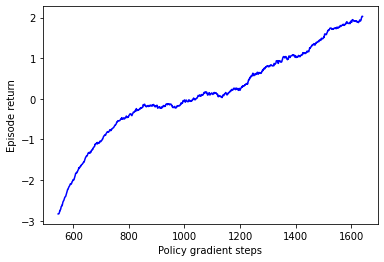

In [83]:
params = default_params()
params['plot_train_samples'] = False
params['plot_frequency'] = 4
params['batch_size'] = int(1e5)
params['offpolicy_iterations'] = 10
# params['epsilon_start'] = 0.5
# params['epsilon_finish'] = 0
params['max_batch_episodes'] = int(300)
params['mini_batch_size'] = int(700)
# params['max_episode_length'] = int(3)
# params['epsilon_finish'] = 0.05
# params['epsilon_anneal_time'] = 70000
env = EnvWrapper(params.get('pref_pace'), params.get('target_pace'))
n_actions, state_dim = params.get('num_actions'), params.get('states_shape')[0]
# The model has n_action policy heads and one value head
model_actor = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, n_actions))
model_critic = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 1))
model_w = th.nn.Sequential(th.nn.Linear(state_dim, 128), th.nn.ReLU(),
                         th.nn.Linear(128, 1), th.nn.Softplus())
model = [model_actor, model_critic, model_w]
experiment = BatchActorCriticExperiment(params, model, learner=BatchOffpolicyActorCriticLearner(model, params=params))

try:
    experiment.run(batch['buffer'])
except KeyboardInterrupt:
    experiment.close()

return_dict = {}
return_dict.update({'model' : 'Batch OFFPAC',
                            'experiment': experiment})
batch_experiments = np.append(batch_experiments, return_dict)

In [46]:
def plot_experiments(experiments):
    # sns.set()
    colors = ['r', 'b', 'r:', 'b:', 'c', 'm']
    plt.figure(figsize=(8, 6), dpi=80)
    i = 0
    for exp in experiments:
        # Smooth curves
        window = max(int(len(exp['experiment'].episode_returns) / 5), 1)
        # if len(exp.episode_losses) < window + 2: return
        returns = np.convolve(exp['experiment'].episode_returns, np.ones(window) / window, 'valid')
        # Determine x-axis based on samples or episodes
        x_returns = [i + window for i in range(len(returns))]
        plt.plot(x_returns, returns, colors[i], label=exp['model'])
        plt.xlabel('Policy gradient step')
        plt.ylabel('Episode return')
        i+=1
    plt.legend()
    plt.title('Running environment')
    # plt.savefig('running_comp_3000_exp_batch.pdf')

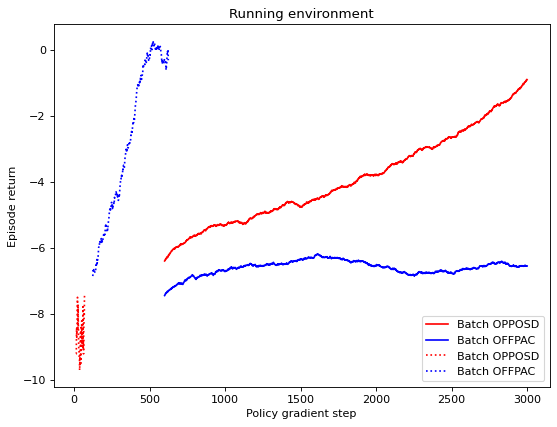

In [47]:
plot_experiments(batch_experiments)

In [32]:
dbfile = open('OFF-PAC-EXPERIMENTS_IMPORTANT_list-of-experiments', 'ab')
pickle.dump(batch_experiments, dbfile)
dbfile.close()
for exp in batch_experiments:
    # Smooth curves
    np.savetxt("%s_EXPERIMENT.csv"%(exp['model']), exp['experiment'].episode_returns, delimiter=",")

In [169]:
def get_probabilities(state):
    actions_prob = th.empty(0)
    for row in state:
        val = row - 0.1
        if abs(val) > 0.6032526790300863:
            actions_prob = th.cat([actions_prob, th.tensor([[0.01, 0.01, 0.01, 0.01, 0.96]])], dim=0)

        elif abs(val) > 0.5087411165497815:
            actions_prob = th.cat([actions_prob, th.tensor([[0.01, 0.01, 0.01, 0.96, 0.01]])], dim=0)

        elif abs(val) > 0.37642492907735484:
            actions_prob = th.cat([actions_prob, th.tensor([[0.01, 0.01, 0.96, 0.01, 0.01]])], dim=0)

        elif abs(val) > 0.1883564663640196:
            actions_prob = th.cat([actions_prob, th.tensor([[0.01, 0.96, 0.01, 0.01, 0.01]])], dim=0)

        else:
            actions_prob = th.cat([actions_prob, th.tensor([[0.96, 0.01, 0.01, 0.01, 0.01]])], dim=0)

    return actions_prob

In [185]:
number = 3000
# state 0
states = np.random.randint(-6, high=28, size=(number,))
# state 1
states = np.append(states, np.random.randint(29, high=47, size=int(number/2,)))
states = np.append(states, np.random.randint(-27, high=-7, size=int(number/2,)))
# state 2
states = np.append(states, np.random.randint(48, high=60, size=int(number/2,)))
states = np.append(states, np.random.randint(-40, high=-28, size=int(number/2,)))
# state 3
states = np.append(states, np.random.randint(61, high=70, size=int(number/2,)))
states = np.append(states, np.random.randint(-50, high=-41, size=int(number/2,)))
# state 4
states = np.append(states, np.random.randint(71, high=110, size=int(number/2,)))
states = np.append(states, np.random.randint(-110, high=-51, size=int(number/2,)))

states = states / 100
states = th.tensor(states, dtype=th.float32).unsqueeze(dim=-1)

# nomalized_data = (states - th.mean(states)) / th.sqrt(th.var(states))

y = get_probabilities(states)

data = np.append(states, y, axis=-1)

trainloader = th.utils.data.DataLoader(data, batch_size=50,
                                          shuffle=True)

In [186]:
losses = []
init_optimizer = th.optim.SGD(model_actor.parameters(), lr=0.02, momentum=0.9)
init_loss_func = th.nn.CrossEntropyLoss()
for epoch in range (20):
    loss_ep = []
    for x in trainloader:
        init_optimizer.zero_grad()
        y = x[:,-5:]
        mx = model_actor(x[:, 0].unsqueeze(dim=-1))[:, :n_actions]
        pred = th.nn.functional.softmax(mx, dim=-1)
        loss = init_loss_func(pred, y)
        loss_ep = np.append(loss_ep, loss.detach())
        loss.backward()
        init_optimizer.step()

    losses = np.append(losses, np.mean(loss_ep))
    if (epoch + 1)% 5 == 0:
        print('Epoch: %s, Loss: %f'% (epoch, losses[-1:]))

Epoch: 4, Loss: 1.164741
Epoch: 9, Loss: 1.158370
Epoch: 14, Loss: 1.154312
Epoch: 19, Loss: 1.151162


4.14


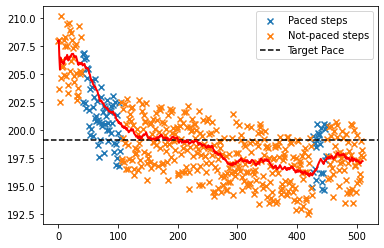

[9.]


In [174]:
test_in_environment(experiment, env)

In [86]:
# env.reset()
print(env.step(0))

(array([-0.1875574]), array([-1.]), 1)


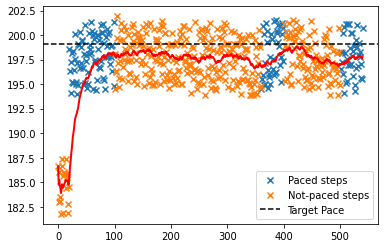

In [208]:
x = np.linspace(0, len(env.env_pacing), len(env.env_pacing))
plt.figure()
plt.scatter(x[np.array(env.env_pacing) == 1], np.array(env.pace)[np.array(env.env_pacing) == 1], marker="x",
            label='Paced steps')
plt.scatter(x[np.array(env.env_pacing) == 0], np.array(env.pace)[np.array(env.env_pacing) == 0], marker="x",
            label='Not-paced steps')

# plt.scatter(x[np.array(env_pacing)==1], np.array(pace)[np.array(env_pacing)==1], marker="x", label='Paced steps')
# plt.scatter(x[np.array(env_pacing)==0], np.array(pace)[np.array(env_pacing)==0], marker="x", label='Not-paced steps')

# plt.scatter(x[np.array(pacing)==1], np.array(pacing)[np.array(pacing)==1]*181, color='r', marker="x")
plt.axhline(y=target_pace, color='k', linestyle='--', label='Target Pace')

plt.plot(x, env.state_traj, 'r-', linewidth=2)
plt.legend()

In [209]:
state = th.tensor(env.reset(), dtype=th.float32).unsqueeze(dim=-1)
y = get_probabilities(state)
print(state)
# state = (state - th.mean(states)) / th.sqrt(th.var(states))
# print(state)

mx = model_actor(state)[:, :n_actions]
pred = th.nn.functional.softmax(mx, dim=-1)
action = th.distributions.Categorical(probs=pred).sample()
print(action)
# print(model(state))
print(pred)
print(y)
# print(init_loss_func(pred, y))

tensor([[1.4814]])
tensor([0])
tensor([[9.9694e-01, 1.2431e-04, 1.0056e-04, 2.7626e-03, 7.4465e-05]],
       grad_fn=<SoftmaxBackward0>)
tensor([[0.0100, 0.0100, 0.0100, 0.0100, 0.9600]])


In [207]:
# test_in_environment(experiment, env)
state = env.reset()
done = 0
rewards = 0
while not done:
    print(experiment.controller.probabilities(state))
    pred = th.nn.functional.softmax(model_actor(th.tensor(state, dtype=th.float32).unsqueeze(dim=-1))[:, :n_actions], dim=-1)
    action = th.distributions.Categorical(probs=pred).sample()
    print(state, action)
    new_state, reward, done = env.step(action)
    rewards += reward
    # if reward < 0:
    #     print(action, state, new_state, reward)
    # if (action != 5):
    # #     # print(action, (state+1)*pref_pace, (new_state+1)*pref_pace, reward)
    # print(action, state, new_state, reward)
    state = new_state
print(rewards)

tensor([[1.2838e-29, 9.0376e-24, 6.8359e-17, 1.0237e-23, 1.0000e+00]],
       grad_fn=<AddBackward0>)
[-1.17106991] tensor([4])
tensor([[2.7966e-03, 3.9085e-07, 1.8883e-06, 2.8032e-07, 9.9720e-01]],
       grad_fn=<AddBackward0>)
[-0.04376169] tensor([4])
tensor([[9.9955e-01, 3.9345e-07, 7.0326e-08, 1.6436e-07, 4.5334e-04]],
       grad_fn=<AddBackward0>)
[0.09455546] tensor([0])
tensor([[9.9966e-01, 3.6880e-07, 6.3895e-08, 1.5731e-07, 3.4371e-04]],
       grad_fn=<AddBackward0>)
[0.09941073] tensor([0])
tensor([[9.9888e-01, 5.2879e-07, 1.1061e-07, 2.2155e-07, 1.1198e-03]],
       grad_fn=<AddBackward0>)
[0.0834741] tensor([0])
tensor([[9.9993e-01, 2.0044e-07, 4.4671e-08, 1.1669e-07, 6.4960e-05]],
       grad_fn=<AddBackward0>)
[0.13810545] tensor([0])
tensor([[9.9977e-01, 3.2054e-07, 5.6132e-08, 1.4456e-07, 2.3266e-04]],
       grad_fn=<AddBackward0>)
[0.10648331] tensor([0])
tensor([[9.9499e-01, 8.7271e-07, 2.3893e-07, 3.6970e-07, 5.0047e-03]],
       grad_fn=<AddBackward0>)
[0.06533

In [123]:
def plot_experiments(experiments):
    # sns.set()
    colors = ['r', 'b', 'r:', 'b:', 'c', 'm']
    plt.figure(figsize=(8, 6), dpi=80)
    i = 0
    for exp in experiments:
        # Smooth curves
        window = max(int(len(exp['data']) / 50), 1)
        # if len(exp.episode_losses) < window + 2: return
        returns = np.convolve(exp['data'], np.ones(window) / window, 'valid')
        # Determine x-axis based on samples or episodes
        x_returns = [i + window for i in range(len(returns))]
        plt.plot(x_returns, returns, colors[i], label=exp['model'])
        plt.xlabel('Policy gradient step')
        plt.ylabel('Episode return')
        i+=1
    plt.legend()
    plt.title('Running environment')
    plt.savefig('running_comp_10000_exp_batch_extra_res.pdf')

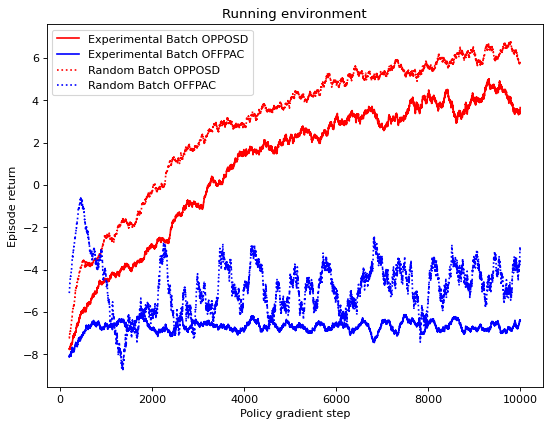

In [124]:
import numpy as np
from numpy import genfromtxt
experiments = []
for file, name in zip(['Experimental-Batch-OPPOSD-10000_EXPERIMENT', 'Experimental-Batch-OFFPAC-10000_EXPERIMENT', 'Random-Batch-OPPOSD-10000_EXPERIMENT', 'Random-Batch-OFFPAC-10000_EXPERIMENT'], ['Experimental Batch OPPOSD', 'Experimental Batch OFFPAC', 'Random Batch OPPOSD', 'Random Batch OFFPAC']):
    return_dict = {}
    my_data = genfromtxt('%s.csv'%file, delimiter=',')
    return_dict.update({'model' : name,
                        'data': my_data})
    experiments = np.append(experiments, return_dict)
plot_experiments(experiments)

<Figure size 432x288 with 0 Axes>

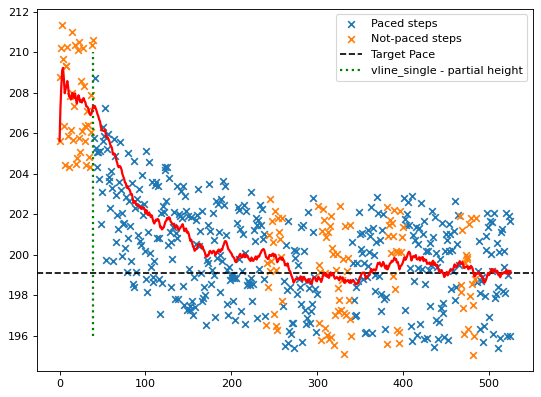

In [130]:
x = np.linspace(0, len(env.env_pacing), len(env.env_pacing))
plt.figure()
plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(x[np.array(env.env_pacing) == 1], np.array(env.pace)[np.array(env.env_pacing) == 1], marker="x",
            label='Paced steps')
plt.scatter(x[np.array(env.env_pacing) == 0], np.array(env.pace)[np.array(env.env_pacing) == 0], marker="x",
            label='Not-paced steps')

# plt.scatter(x[np.array(env_pacing)==1], np.array(pace)[np.array(env_pacing)==1], marker="x", label='Paced steps')
# plt.scatter(x[np.array(env_pacing)==0], np.array(pace)[np.array(env_pacing)==0], marker="x", label='Not-paced steps')

# plt.scatter(x[np.array(pacing)==1], np.array(pacing)[np.array(pacing)==1]*181, color='r', marker="x")
plt.axhline(y=target_pace, color='k', linestyle='--', label='Target Pace')
plt.vlines(x=39.25, ymin=196, ymax=210, colors='green', ls=':', lw=2, label='vline_single - partial height')

plt.plot(x, env.state_traj, 'r-', linewidth=2)
plt.legend()

<Figure size 432x288 with 0 Axes>

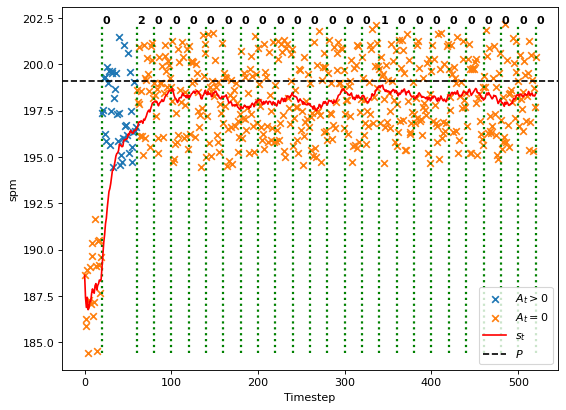

[3.]


In [189]:

state = env.reset()
transitions = [20]
reward_value = [0]
rewards = 0
done = 0

while not done:
    pred = th.nn.functional.softmax(model_actor(th.tensor(state, dtype=th.float32).unsqueeze(dim=-1))[:, :n_actions], dim=-1)
    action = th.distributions.Categorical(probs=pred).sample()
    # action = np.random.randint(0,4)
    new_state, reward, done = env.step(action)
    # if reward < 0:
    #     print(action, state, new_state, reward)
    # if (action != 5):
    # #     # print(action, (state+1)*pref_pace, (new_state+1)*pref_pace, reward)
    # print(action, state, new_state, reward)
    transitions = np.append(transitions, env.steps)
    reward_value = np.append(reward_value, reward)
    rewards += reward
    state = new_state

x = np.linspace(0, len(env.env_pacing), len(env.env_pacing))
plt.figure()
plt.figure(figsize=(8, 6), dpi=80)
plt.scatter(x[np.array(env.env_pacing) == 1], np.array(env.pace)[np.array(env.env_pacing) == 1], marker="x",
            label='$A_t > 0$')
plt.scatter(x[np.array(env.env_pacing) == 0], np.array(env.pace)[np.array(env.env_pacing) == 0], marker="x",
            label='$A_t = 0$')

for act, rwd in zip(transitions, reward_value):
    plt.vlines(x=act, ymin=np.min(env.pace), ymax=np.max(env.pace), colors='green', ls=':', lw=2)
    plt.text(act+1, np.max(env.pace), '%d'%(rwd), weight="bold")


# plt.scatter(x[np.array(env_pacing)==1], np.array(pace)[np.array(env_pacing)==1], marker="x", label='Paced steps')
# plt.scatter(x[np.array(env_pacing)==0], np.array(pace)[np.array(env_pacing)==0], marker="x", label='Not-paced steps')

# plt.scatter(x[np.array(pacing)==1], np.array(pacing)[np.array(pacing)==1]*181, color='r', marker="x")
plt.plot(x, env.state_traj, 'r', linewidth=1.5, label='$s_t$')
plt.axhline(y=target_pace, color='k', linestyle='--', label='$P$')

# plt.title('Simulation (target pace=%d)'%(env.target_pace))

plt.xlabel('Timestep')
plt.ylabel('spm')

plt.legend()
plt.show()
print(rewards)

In [192]:
done = False
env.reset()
state = env.step(0)[0]
try_scores = []

for _ in range(500):
    env.reset()
    state = env.step(0)[0]
    done = False
    score = 0
    time_step = 0
    while not done:
        pred = th.nn.functional.softmax(model_actor(th.tensor(state, dtype=th.float32).unsqueeze(dim=-1))[:, :n_actions], dim=-1)
        action = th.distributions.Categorical(probs=pred).sample()
        new_state, reward, done = env.step(action)
        score += reward
        state = new_state
    try_scores.append(score)
print(np.array(try_scores).mean())

4.01
